In [ ]:
!pip install ibmos2spark
!pip install tensorflow==2.0.0b1

print("NEED TO RESTART KERNAL")
print("NEED TO RESTART KERNAL")
print("NEED TO RESTART KERNAL")

    100% |################################| 87.9MB 248kB/s eta 0:00:01
    100% |################################| 51kB 1.9MB/s eta 0:00:01
    100% |################################| 112kB 3.8MB/s eta 0:00:01
    100% |################################| 3.1MB 2.2MB/s eta 0:00:01
    100% |################################| 501kB 3.6MB/s eta 0:00:01
    100% |################################| 61kB 2.4MB/s eta 0:00:01
    100% |################################| 20.4MB 711kB/s eta 0:00:01
    100% |################################| 51kB 2.5MB/s eta 0:00:01
    100% |################################| 2.2MB 2.7MB/s eta 0:00:01
    100% |################################| 1.2MB 3.9MB/s eta 0:00:01
    100% |################################| 92kB 4.2MB/s eta 0:00:01
    100% |################################| 337kB 2.9MB/s eta 0:00:01
    100% |################################| 583kB 4.1MB/s eta 0:00:01
    100% |################################| 2.8MB 2.9MB/s eta 0:00:01
  Stored in directory:

In [1]:
import tensorflow as tf
print(tf.__version__)
print("SHOULD SEE: 2.0.0-beta1")

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190831165529-0001
KERNEL_ID = 160a310a-b408-45b7-9677-e477687b2f09


/home/spark/shared/user-libs/python3/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/spark/shared/user-libs/python3/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/spark/shared/user-libs/python3/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/spark/shared/user-libs/python3/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' 

2.0.0-beta1
SHOULD SEE: 2.0.0-beta1


In [57]:
# Configuration

# 'countries' list used to iterate
 

countries = ['Australia', 'Brazil', 'Canada', 
         'Denmark', 'EU', 'India', 'Japan',
         'New_Zealand', 'Norway',
         'Singapore', 'South_Africa', 'South_Korea',
         'Sri_Lanka', 'Sweden', 'Switzerland', 'Taiwan',
         'Thailand', 'United_Kingdom']

target_countries = []

# Removing the following countries from training due to currency collapse
# during the interval.
# 
# ['Venezuela']
#
# Removing the following because low variance demonstrates a fixed-currency
# over the interval
#
# ['Hong_Kong', 'China', 'Malaysia']

this_stage = "feature_eng"
previous_stage = "etl"

In [3]:
import ibmos2spark
from pyspark.sql.types import *

# Configuration
# Prepare to access IBM Object Storage

# @hidden_cell
credentials = {
    'service_id': 'iam-ServiceId-e4b1b62b-e030-4b68-a71f-a12e44f23c33',
    'api_key': '9-RaWWhWwA-jm5BkfQ1pxtj-J5xvpjYKMrSgMk9vQxX1',
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'bucket': 'forex-donotdelete-pr-ksiby6mz5os7oj'
}

# configuration_name = 'os_forex'
configuration_name = ''
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

print(type(cos))

bucket_name = 'forex-donotdelete-pr-ksiby6mz5os7oj'

<class 'ibmos2spark.osconfig.CloudObjectStorage'>


In [4]:
data_url = cos.url(previous_stage + ".parquet", bucket_name)
df = spark.read.format("parquet").load(data_url)
df = df.sort('Date', ascending=True)

In [8]:
def windowed_dataset_noprefetch(series, window_size, batch_size, shuffle_buffer=None):
    # Add a dimension to the tensor in the last position (-1)
    series = tf.expand_dims(series, axis=-1)
    # Create a tf Dataset object from the numpy tensor
    ds = tf.data.Dataset.from_tensor_slices(series)
    # Create windows of window_size + 1 (target)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # shuffles after correct training sequences exist
    if shuffle_buffer == None:
        pass
    else:
        ds = ds.shuffle(shuffle_buffer) 
    # Create 
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size)

In [58]:
import numpy as np

############################
# Basic model hyperparams  #
############################

# Since a week is represented by the 5 days (Mon-Fri) when an exhange
# rate trade can be made, one month is roughly 20 time steps.
window_size = 20
batch_size = 160
shuffle_buffer_size = 1000

all_series = {}
all_train = {}
all_valid = {}
split_time = 0
time_len = 0
count = 0

load_data = False

# MIKE: 1) need to calculate the ROLLING VARIANCE over window_size
#          for each of the currencies to check for pegged rates.
#       2) it may also be useful to look for seasonality by running 
#          each series through a Fourier Transform
#       3) some analysis of correlations between the series may be 
#          appropriate
#       4) day_of_week & month might be features worth adding
#       5) CANNOT string together the various countries' rates because
#          the overlapping sequences will destroy the model during training

for country in countries:
    if load_data == True:
        series = np.array(df.select(country).collect()) 
        series = series.reshape(series.shape[0])
        all_series[country] = series
    else:
        series = all_series[country]
        
    max_rate = np.max(series)
    min_rate = np.min(series)
    all_series[country+"_max_rate"] = max_rate 
    all_series[country+"_min_rate"] = min_rate 

    ###########################################
    # Splitting data for train/validation at  #
    # the middle of the time interval         #
    ###########################################
    # Centering the data by subtracing the minimum: " + str(min_rate)
    series = series - min_rate
    # Normalizing the data dividing by (max - min): " + str(max_rate) + " - " + str(min_rate)
    series = series / (max_rate - min_rate) 
    
    x_train_len = (len(series) // 10) * 9
    x_train = series[0:x_train_len]
    all_train[country] = x_train
    all_train[country+"_len"] = x_train_len
    all_train[country+"_min"] = min_rate
    all_train[country+"_max"] = max_rate
    
    print(country + " has " + str(x_train_len) + " training rows.")

    split_time = split_time + x_train_len

    x_valid = series[x_train_len:-1]
    all_valid[country] = x_valid
    x_valid_len = x_valid.shape[0]    
    all_valid[country+"_len"] = x_valid_len
    print(country + " has " + str(x_valid_len) + " validation rows.")

    time_len = time_len + x_train_len + x_valid_len
    
    if count==0:
        train_set = windowed_dataset_noprefetch(all_train[country], window_size, batch_size, shuffle_buffer_size)
        valid_set = windowed_dataset_noprefetch(all_valid[country], window_size, batch_size, shuffle_buffer_size)
    else:
        train_set = train_set.concatenate(windowed_dataset_noprefetch(all_train[country], window_size, batch_size, shuffle_buffer_size))
        valid_set = valid_set.concatenate(windowed_dataset_noprefetch(all_valid[country], window_size, batch_size, shuffle_buffer_size))
    count+=1

train_set = train_set.prefetch(1)
valid_set = valid_set.prefetch(1)
###########################################
# Splitting time indices for visualizing  #
###########################################

time = np.array(range(time_len))
time_train = time[:split_time]
time_valid = time[split_time:]

Australia has 4419 training rows.
Australia has 491 validation rows.
Brazil has 4419 training rows.
Brazil has 491 validation rows.
Canada has 4419 training rows.
Canada has 491 validation rows.
Denmark has 4419 training rows.
Denmark has 491 validation rows.
EU has 4419 training rows.
EU has 491 validation rows.
India has 4419 training rows.
India has 491 validation rows.
Japan has 4419 training rows.
Japan has 491 validation rows.
New_Zealand has 4419 training rows.
New_Zealand has 491 validation rows.
Norway has 4419 training rows.
Norway has 491 validation rows.
Singapore has 4419 training rows.
Singapore has 491 validation rows.
South_Africa has 4419 training rows.
South_Africa has 491 validation rows.
South_Korea has 4419 training rows.
South_Korea has 491 validation rows.
Sri_Lanka has 4419 training rows.
Sri_Lanka has 491 validation rows.
Sweden has 4419 training rows.
Sweden has 491 validation rows.
Switzerland has 4419 training rows.
Switzerland has 491 validation rows.
Taiwa

In [ ]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
#  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
#                      strides=1, padding="causal",
#                      activation="relu",
#                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(40, return_sequences=True),
  tf.keras.layers.LSTM(20, return_sequences=True),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dropout(0.05),
#  tf.keras.layers.Dense(10, activation="relu"),
#  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(1)
#  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = 'adam'
model.compile(loss='mae',
              optimizer=optimizer,
              metrics=['mae']) 
history = model.fit(train_set, epochs=25, validation_data = valid_set)

for layer in model.layers:
  #layer.trainable = False
  print(layer.name)

    # Save entire model to a HDF5 file
local_weights_file = 'all_countries_model.h5'
model.save(local_weights_file)

model.summary()

Epoch 1/25
504/504 [==============================] - 29s 58ms/step - loss: 0.0761 - mae: 0.1367 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/25
504/504 [==============================] - 24s 47ms/step - loss: 0.0260 - mae: 0.0286 - val_loss: 0.0175 - val_mae: 0.0175
Epoch 3/25
504/504 [==============================] - 24s 47ms/step - loss: 0.0199 - mae: 0.0212 - val_loss: 0.0129 - val_mae: 0.0129
Epoch 4/25
504/504 [==============================] - 24s 47ms/step - loss: 0.0177 - mae: 0.0182 - val_loss: 0.0131 - val_mae: 0.0131
Epoch 5/25
504/504 [==============================] - 24s 47ms/step - loss: 0.0167 - mae: 0.0172 - val_loss: 0.0120 - val_mae: 0.0120
Epoch 6/25
504/504 [==============================] - 24s 48ms/step - loss: 0.0164 - mae: 0.0168 - val_loss: 0.0114 - val_mae: 0.0114
Epoch 7/25
504/504 [==============================] - 24s 47ms/step - loss: 0.0161 - mae: 0.0164 - val_loss: 0.0110 - val_mae: 0.0110
Epoch 8/25
504/504 [==============================] - 

In [31]:
# DO NOT RUN
# DO NOT RUN
# DO NOT RUN

count=0
for country in target_countries:
    series = np.array(df.select(country).collect()) 
    series = series.reshape(series.shape[0])
    all_series[country] = series
    max_rate = np.max(series)
    min_rate = np.min(series)
    all_series[country+"_max_rate"] = max_rate 
    all_series[country+"_min_rate"] = min_rate 

    ###########################################
    # Splitting data for train/validation at  #
    # the middle of the time interval         #
    ###########################################
    # x_train = createEvenlyDivisible(x_train, batch_size)
    print("Centering the data by subtracing the minimum: " + str(min_rate))
    series = series - min_rate
    print("Normalizing the data dividing by (max - min): " + str(max_rate) + " - " + str(min_rate))
    series = series / (max_rate - min_rate) 
    
    x_train_len = (len(series) // 10) * 7
    x_train = series[0:x_train_len]
    all_train[country] = x_train
    all_train[country+"_len"] = x_train_len
    all_train[country+"_min"] = min_rate
    all_train[country+"_max"] = max_rate
    
    print(country + " has " + str(x_train_len) + " training rows.")

    split_time = split_time + x_train_len

    x_valid = series[x_train_len:-1]
    all_valid[country] = x_valid
    x_valid_len = x_valid.shape[0]    
    all_valid[country+"_len"] = x_valid_len
    print(country + " has " + str(x_valid_len) + " validation rows.")

    time_len = time_len + x_train_len + x_valid_len
    
    if count==0:
        last_train_set = windowed_dataset_noprefetch(all_train[country], window_size, batch_size, shuffle_buffer_size)
        last_valid_set = windowed_dataset_noprefetch(all_valid[country], window_size, batch_size, shuffle_buffer_size)
    else:
        last_train_set = train_set.concatenate(windowed_dataset_noprefetch(all_train[country], window_size, batch_size, shuffle_buffer_size))
        last_valid_set = valid_set.concatenate(windowed_dataset_noprefetch(all_valid[country], window_size, batch_size, shuffle_buffer_size))
    count+=1

last_train_set = last_train_set.prefetch(1)
last_valid_set = last_valid_set.prefetch(1)
###########################################
# Splitting time indices for visualizing  #
###########################################

time = np.array(range(time_len))
time_train = time[:split_time]
time_valid = time[split_time:]

Centering the data by subtracing the minimum: 1.2066999673843384
Normalizing the data dividing by (max - min): 2.1103999614715576 - 1.2066999673843384
United_Kingdom has 3437 training rows.
United_Kingdom has 1473 validation rows.


In [33]:
# DO NOT RUN
# DO NOT RUN
# DO NOT RUN

tf.keras.backend.clear_session()

last_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(40, return_sequences=True),
  tf.keras.layers.LSTM(20, return_sequences=True),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.05),
#  tf.keras.layers.Dense(10, activation="relu"),
#  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Dense(1)
#  tf.keras.layers.Lambda(lambda x: x * 400)
])

#fixed = ["conv1d", "lstm"]
fixed = []

for layer in last_model.layers:
    if layer.name in fixed:
      layer.trainable = False
      print("Fixing layer: " + layer.name)
    else:
      print("Skipping: " + layer.name)
    
optimizer = 'adam'
last_model.compile(loss='mae',
              optimizer=optimizer,
              metrics=['mae']) 

last_model.load_weights(local_weights_file)

Skipping: lstm
Skipping: lstm_1
Skipping: dense
Skipping: dropout
Skipping: dense_1


ValueError: Weights for model sequential have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [44]:
last_history = model.fit(last_train_set, epochs=25, validation_data = last_valid_set)

# Save entire model to a HDF5 file
last_model.save('last_countries_model.h5')

# Optimizers:
# 'adam'
# tf.keras.optimizers.RMSprop()
# tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

# Loss:
# tf.keras.losses.Huber()

Epoch 1/25
22/22 [==============================] - 3s 142ms/step - loss: 0.0168 - mae: 0.0169 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/25
22/22 [==============================] - 2s 69ms/step - loss: 0.0163 - mae: 0.0164 - val_loss: 0.0104 - val_mae: 0.0105
Epoch 3/25
22/22 [==============================] - 1s 67ms/step - loss: 0.0164 - mae: 0.0165 - val_loss: 0.0112 - val_mae: 0.0113
Epoch 4/25
22/22 [==============================] - 2s 69ms/step - loss: 0.0164 - mae: 0.0164 - val_loss: 0.0111 - val_mae: 0.0112
Epoch 5/25
22/22 [==============================] - 2s 69ms/step - loss: 0.0166 - mae: 0.0167 - val_loss: 0.0112 - val_mae: 0.0113
Epoch 6/25
22/22 [==============================] - 2s 69ms/step - loss: 0.0164 - mae: 0.0164 - val_loss: 0.0116 - val_mae: 0.0118
Epoch 7/25
22/22 [==============================] - 1s 67ms/step - loss: 0.0162 - mae: 0.0162 - val_loss: 0.0122 - val_mae: 0.0124
Epoch 8/25
22/22 [==============================] - 1s 67ms/step - loss: 0

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
lstm (LSTM)                  (None, None, 40)          16800     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          4880      
_________________________________________________________________
dense (Dense)                (None, None, 10)          210       
_________________________________________________________________
dropout (Dropout)            (None, None, 10)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           11        
Total params: 22,285
Trainable params: 22,285
Non-trainable params: 0
____________________________________________________

In [37]:
###################################################################
# Creating some utility functions to:
# 1. create tf Dataset objects from numpy arrays
# 2. generate instances of windows given a size 'window_size'
#    which will become a training sequence instance
# 3. keeps batches of 'batch_size' together
# 4. randomizes sequences using 'shuffle' within the batches  
########################################################################
# windowed_dataset
# 
# series: 1D numpy array with rates
# window_size: integer defining the number of time-steps per sequence
# batch_size: integer defining number of instances per training epoch
# shuffle_buffer: size of buffer for randomizing data
#
# returns a tf.data.Dataset ready for LSTM model input
########################################################################
def windowed_dataset(series, window_size, batch_size, shuffle_buffer=None):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # shuffles after correct training sequences exist
    if shuffle_buffer == None:
        pass
    else:
        ds = ds.shuffle(shuffle_buffer) 
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

############################################################################
# model_forecast
# 
# model: tf model type 
# series: 1D numpy array with rates
# window_size: integer defining the number of time-steps per sequence
# batch_size: integer defining number of instances per training epoch
# cnn: boolean describing whether or not a CNN is used on the input, in
#      which case the input dimension needs to be adjusted
#
# returns a tf.data.Dataset resulting from running inference over the data
############################################################################
def model_forecast(model, series, window_size, batch_size=32, cnn=False):
    if cnn == True:
        series = series[..., np.newaxis]
    else:
        pass
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast


In [49]:
# The intention is to train a general purpose model initially,
# which can be used later using transfer learning to create 
# pairwise exchange rate predictors (e.g. for rates between two
# specific countries)
#
# Therefor, the data needs to be organized as 18 separate sequences.
# It would be beneficial to use a different 'split_time' to 
# separate each country's train / test split so as to train
# using a sample over the complete time interval, but we will 
# start by just splitting at the time midpoint.

import matplotlib.pyplot as plt
%matplotlib inline

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Rate")
    plt.grid(True)
    

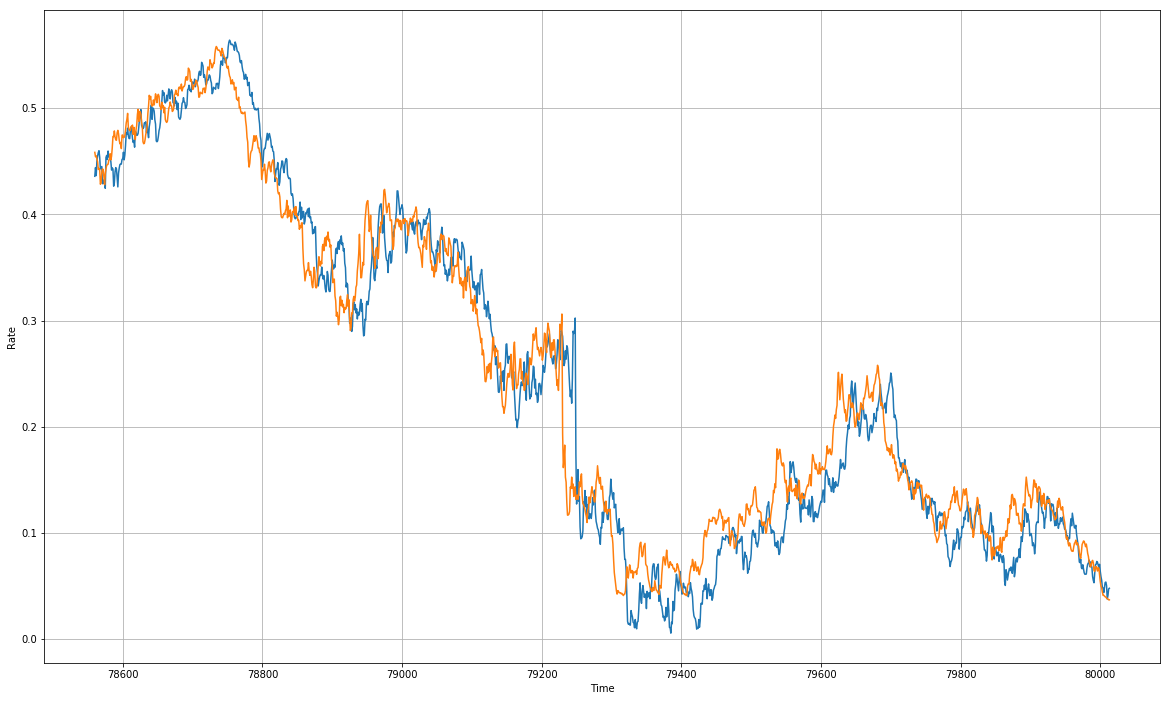

In [52]:
import matplotlib.pyplot as plt

# np. newaxis is used to increase the dimension of the existing array 
# by one dimension

rnn_forecast = model_forecast(model, all_valid["United_Kingdom"], window_size, cnn=False)
rnn_forecast = rnn_forecast[:x_valid_len-window_size+1, -1, 0]

#rnn_forecast = rnn_forecast[x_train_len - window_size:-1, -1, 0]

plt.figure(figsize=(20, 12))
#plot_series(time_valid, x_valid)
#plot_series(time_valid, rnn_forecast)
plot_series(time_valid[:x_valid_len - window_size+1], all_valid["United_Kingdom"][:x_valid_len - window_size+1])
plot_series(time_valid[:x_valid_len - window_size+1], rnn_forecast)

#plt.axis([10e-8, 10e-5, 0, 0.5])
plt.show()

In [47]:
x_valid_len

1473

In [239]:
#train_set = train_set.prefetch(1)
#valid_set = valid_set.prefetch(1)

for x,y in train_set:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

#count = 0
#for window_dataset in train_set:
#  print(len(window_dataset))
#  for win in window_dataset:
#    print(win.numpy().shape)
#    print(win.numpy(), end=" ")
#    a = win.numpy().shape
#    count+=1

2
(160, 20, 1)
[[[0.31978057]
  [0.31639239]
  [0.31558564]
  ...
  [0.33623753]
  [0.33720555]
  [0.33994835]]

 [[0.17376572]
  [0.17134557]
  [0.15714749]
  ...
  [0.1164892 ]
  [0.10680868]
  [0.10035497]]

 [[0.05679252]
  [0.05824455]
  [0.05275896]
  ...
  [0.03904489]
  [0.04453048]
  [0.04791866]]

 ...

 [[0.06324622]
  [0.06082607]
  [0.05840592]
  ...
  [0.10003224]
  [0.10358178]
  [0.09954822]]

 [[0.28267182]
  [0.28186517]
  [0.28509197]
  ...
  [0.3255889 ]
  [0.32042595]
  [0.32591163]]

 [[0.22071636]
  [0.2123266 ]
  [0.21732818]
  ...
  [0.1999032 ]
  [0.19958056]
  [0.20522751]]] (160, 20, 1)
[[[0.31639239]
  [0.31558564]
  [0.31752179]
  ...
  [0.33720555]
  [0.33994835]
  [0.34979023]]

 [[0.17134557]
  [0.15714749]
  [0.14198129]
  ...
  [0.10680868]
  [0.10035497]
  [0.09503066]]

 [[0.05824455]
  [0.05275896]
  [0.04953206]
  ...
  [0.04453048]
  [0.04791866]
  [0.04178769]]

 ...

 [[0.06082607]
  [0.05840592]
  [0.06050333]
  ...
  [0.10358178]
  [0.0995482

[[[0.48354314]
  [0.48531781]
  [0.49499842]
  [0.49790259]
  [0.49467568]
  [0.48967411]
  [0.49177152]
  [0.49709584]
  [0.48935137]
  [0.48612456]
  [0.48693131]
  [0.49031949]
  [0.48596319]
  [0.48370441]
  [0.47870283]
  [0.4864473 ]
  [0.48902873]
  [0.48789933]
  [0.48434979]
  [0.48418842]]

 [[0.78944827]
  [0.8017103 ]
  [0.79590197]
  [0.7941272 ]
  [0.79057766]
  [0.79396583]
  [0.78848015]
  [0.7757341 ]
  [0.76508556]
  [0.7637948 ]
  [0.76524684]
  [0.75508231]
  [0.74314301]
  [0.74007748]
  [0.7242659 ]
  [0.72136174]
  [0.69845116]
  [0.68570512]
  [0.68586639]
  [0.65940627]]

 [[0.2817038 ]
  [0.26895775]
  [0.27686349]
  [0.27331395]
  [0.28751212]
  [0.28622136]
  [0.30187157]
  [0.27783151]
  [0.25040337]
  [0.24072286]
  [0.26589222]
  [0.26960313]
  [0.27605684]
  [0.3044531 ]
  [0.32365276]
  [0.28412395]
  [0.27767024]
  [0.27089379]
  [0.28509197]
  [0.2513714 ]]

 [[0.4501452 ]
  [0.45514688]
  [0.46627943]
  [0.4696676 ]
  [0.45869633]
  [0.45563089]
  [0

[[[0.5069254 ]
  [0.5069254 ]
  [0.50974059]
  ...
  [0.53545285]
  [0.54708901]
  [0.58049625]]

 [[0.58049625]
  [0.5883788 ]
  [0.58087158]
  ...
  [0.59776287]
  [0.6030179 ]
  [0.59776287]]

 [[0.10341201]
  [0.10679028]
  [0.10904242]
  ...
  [0.0977816 ]
  [0.10115987]
  [0.09909535]]

 ...

 [[0.70849439]
  [0.70173792]
  [0.69723356]
  ...
  [0.59213241]
  [0.57298894]
  [0.56210354]]

 [[0.65969747]
  [0.6649525 ]
  [0.65932204]
  ...
  [0.74978418]
  [0.75841749]
  [0.76442319]]

 [[0.50054427]
  [0.50279646]
  [0.49829209]
  ...
  [0.48628051]
  [0.50298413]
  [0.50767616]]] (160, 20, 1)
[[[0.5069254 ]
  [0.50974059]
  [0.51743547]
  ...
  [0.54708901]
  [0.58049625]
  [0.5883788 ]]

 [[0.5883788 ]
  [0.58087158]
  [0.59644902]
  ...
  [0.6030179 ]
  [0.59776287]
  [0.59250774]]

 [[0.10679028]
  [0.10904242]
  [0.10716562]
  ...
  [0.10115987]
  [0.09909535]
  [0.09628017]]

 ...

 [[0.70173792]
  [0.69723356]
  [0.6964828 ]
  ...
  [0.57298894]
  [0.56210354]
  [0.5636049

  [0.06962953]]] 2
(160, 20, 1)
[[[0.98864943]
  [0.97514366]
  [0.96724142]
  ...
  [0.96120697]
  [0.97083329]
  [0.97270107]]

 [[0.86479885]
  [0.87744257]
  [0.88261499]
  ...
  [0.92298857]
  [0.91738505]
  [0.90589077]]

 [[0.80158041]
  [0.80416671]
  [0.80287356]
  ...
  [0.81465524]
  [0.81910915]
  [0.81551728]]

 ...

 [[0.85344827]
  [0.86522995]
  [0.86522995]
  ...
  [0.94985639]
  [0.94784491]
  [0.94209768]]

 [[0.77227017]
  [0.76752869]
  [0.77399425]
  ...
  [0.78117815]
  [0.77198277]
  [0.77399425]]

 [[0.60129304]
  [0.59497118]
  [0.58778728]
  ...
  [0.54540221]
  [0.5477011 ]
  [0.55991372]]] (160, 20, 1)
[[[0.97514366]
  [0.96724142]
  [0.96795976]
  ...
  [0.97083329]
  [0.97270107]
  [0.97298848]]

 [[0.87744257]
  [0.88261499]
  [0.87715517]
  ...
  [0.91738505]
  [0.90589077]
  [0.8948276 ]]

 [[0.80416671]
  [0.80287356]
  [0.82025859]
  ...
  [0.81910915]
  [0.81551728]
  [0.82428156]]

 ...

 [[0.86522995]
  [0.86522995]
  [0.87571832]
  ...
  [0.94784

  [0.22586205]]] 2
(160, 20, 1)
[[[0.51293104]
  [0.51522993]
  [0.51178159]
  ...
  [0.46810338]
  [0.46135058]
  [0.44022981]]

 [[0.23318965]
  [0.21293109]
  [0.2179598 ]
  ...
  [0.24525856]
  [0.25847692]
  [0.26724137]]

 [[0.78864946]
  [0.79597706]
  [0.79899429]
  ...
  [0.81048857]
  [0.81566098]
  [0.8110632 ]]

 ...

 [[0.48850581]
  [0.48620692]
  [0.48462637]
  ...
  [0.4948275 ]
  [0.49899417]
  [0.50459769]]

 [[0.11896548]
  [0.12212632]
  [0.11896548]
  ...
  [0.14640802]
  [0.15158044]
  [0.15416656]]

 [[0.28749993]
  [0.29612068]
  [0.30229884]
  ...
  [0.31436775]
  [0.3159483 ]
  [0.31839072]]] (160, 20, 1)
[[[0.51522993]
  [0.51178159]
  [0.49999991]
  ...
  [0.46135058]
  [0.44022981]
  [0.4422413 ]]

 [[0.21293109]
  [0.2179598 ]
  [0.22327575]
  ...
  [0.25847692]
  [0.26724137]
  [0.27183898]]

 [[0.79597706]
  [0.79899429]
  [0.79841948]
  ...
  [0.81566098]
  [0.8110632 ]
  [0.80675283]]

 ...

 [[0.48620692]
  [0.48462637]
  [0.47902302]
  ...
  [0.49899

  [0.36356306]]] 2
(160, 20, 1)
[[[0.83588439]
  [0.8249511 ]
  [0.80688233]
  ...
  [0.84301988]
  [0.82184367]
  [0.83312225]]

 [[0.80642179]
  [0.8055242 ]
  [0.80331458]
  ...
  [0.90931061]
  [0.91759701]
  [0.92680404]]

 [[0.80812521]
  [0.80204865]
  [0.78536083]
  ...
  [0.81654968]
  [0.82207394]
  [0.83197135]]

 ...

 [[0.34468867]
  [0.33812863]
  [0.33133844]
  ...
  [0.36609503]
  [0.3727702 ]
  [0.37161929]]

 [[0.28295546]
  [0.28129814]
  [0.26566925]
  ...
  [0.24543674]
  [0.23931408]
  [0.24444695]]

 [[0.54528713]
  [0.54448151]
  [0.54471167]
  ...
  [0.51133615]
  [0.52238457]
  [0.51939227]]] (160, 20, 1)
[[[0.8249511 ]
  [0.80688233]
  [0.80319934]
  ...
  [0.82184367]
  [0.83312225]
  [0.81602021]]

 [[0.8055242 ]
  [0.80331458]
  [0.81954186]
  ...
  [0.91759701]
  [0.92680404]
  [0.91564049]]

 [[0.80204865]
  [0.78536083]
  [0.78098747]
  ...
  [0.82207394]
  [0.83197135]
  [0.8499251 ]]

 ...

 [[0.33812863]
  [0.33133844]
  [0.32155595]
  ...
  [0.37277

  [0.27022667]]] 2
(160, 20, 1)
[[[0.29579928]
  [0.28997582]
  [0.31439752]
  ...
  [0.33985499]
  [0.34059157]
  [0.34952235]]

 [[0.25149036]
  [0.2476694 ]
  [0.24490738]
  ...
  [0.23031415]
  [0.2309356 ]
  [0.22228108]]

 [[0.32282199]
  [0.34353776]
  [0.34146622]
  ...
  [0.33456089]
  [0.31810334]
  [0.31955344]]

 ...

 [[0.01507648]
  [0.00888479]
  [0.01995626]
  ...
  [0.02172861]
  [0.01790765]
  [0.02874896]]

 [[0.32098049]
  [0.32512369]
  [0.32328231]
  ...
  [0.31814933]
  [0.3198297 ]
  [0.32167108]]

 [[0.27342618]
  [0.26806304]
  [0.26283808]
  ...
  [0.25683045]
  [0.25222693]
  [0.26562315]]] (160, 20, 1)
[[[0.28997582]
  [0.31439752]
  [0.326827  ]
  ...
  [0.34059157]
  [0.34952235]
  [0.34547123]]

 [[0.2476694 ]
  [0.24490738]
  [0.25112212]
  ...
  [0.2309356 ]
  [0.22228108]
  [0.22333979]]

 [[0.34353776]
  [0.34146622]
  [0.35182416]
  ...
  [0.31810334]
  [0.31955344]
  [0.3092416 ]]

 ...

 [[0.00888479]
  [0.01995626]
  [0.02423753]
  ...
  [0.01790

  [0.66900675]]] 2
(160, 20, 1)
[[[0.26511625]
  [0.25981913]
  [0.25839786]
  ...
  [0.19250646]
  [0.19547799]
  [0.20568471]]

 [[0.26976741]
  [0.27661502]
  [0.28294574]
  ...
  [0.31770033]
  [0.32260978]
  [0.33010334]]

 [[0.06472865]
  [0.06524545]
  [0.06266151]
  ...
  [0.16343664]
  [0.15710592]
  [0.14560723]]

 ...

 [[0.49095611]
  [0.48604651]
  [0.48630495]
  ...
  [0.50723511]
  [0.49470289]
  [0.49354006]]

 [[0.01757105]
  [0.0167958 ]
  [0.01214464]
  ...
  [0.04354004]
  [0.03914724]
  [0.03875966]]

 [[0.13204132]
  [0.13359173]
  [0.12751937]
  ...
  [0.14263562]
  [0.14457362]
  [0.1276486 ]]] (160, 20, 1)
[[[0.25981913]
  [0.25839786]
  [0.24005165]
  ...
  [0.19547799]
  [0.20568471]
  [0.2124031 ]]

 [[0.27661502]
  [0.28294574]
  [0.28617563]
  ...
  [0.32260978]
  [0.33010334]
  [0.33178289]]

 [[0.06524545]
  [0.06266151]
  [0.07596898]
  ...
  [0.15710592]
  [0.14560723]
  [0.14431526]]

 ...

 [[0.48604651]
  [0.48630495]
  [0.48850139]
  ...
  [0.49470

  [0.03578813]]] 2
(160, 20, 1)
[[[0.91718357]
  [0.91201553]
  [0.93346257]
  ...
  [0.94935407]
  [0.95568479]
  [0.96447039]]

 [[0.62803618]
  [0.6281654 ]
  [0.62726101]
  ...
  [0.60697679]
  [0.60555552]
  [0.61434113]]

 [[0.11602068]
  [0.1136951 ]
  [0.10956074]
  ...
  [0.09341081]
  [0.09999997]
  [0.09909558]]

 ...

 [[0.65310078]
  [0.64922479]
  [0.651292  ]
  ...
  [0.69198966]
  [0.69160215]
  [0.70335921]]

 [[0.49328162]
  [0.50155034]
  [0.49198972]
  ...
  [0.48785528]
  [0.49651166]
  [0.49211894]]

 [[0.82687344]
  [0.82286823]
  [0.82454778]
  ...
  [0.83255822]
  [0.83100773]
  [0.83100773]]] (160, 20, 1)
[[[0.91201553]
  [0.93346257]
  [0.94496134]
  ...
  [0.95568479]
  [0.96447039]
  [0.961628  ]]

 [[0.6281654 ]
  [0.62726101]
  [0.63152451]
  ...
  [0.60555552]
  [0.61434113]
  [0.60645991]]

 [[0.1136951 ]
  [0.10956074]
  [0.0953488 ]
  ...
  [0.09999997]
  [0.09909558]
  [0.08953489]]

 ...

 [[0.64922479]
  [0.651292  ]
  [0.65826883]
  ...
  [0.69160

  [0.6320414 ]]] 2
(160, 20, 1)
[[[0.24267783]
  [0.24239883]
  [0.24295672]
  ...
  [0.24295672]
  [0.24267783]
  [0.24211994]]

 [[0.26527201]
  [0.2658298 ]
  [0.26499301]
  ...
  [0.26136676]
  [0.26415622]
  [0.26415622]]

 [[0.24128315]
  [0.24100415]
  [0.23737801]
  ...
  [0.23179919]
  [0.22928872]
  [0.23012551]]

 ...

 [[0.23430965]
  [0.23347276]
  [0.2376569 ]
  ...
  [0.2376569 ]
  [0.23849369]
  [0.2376569 ]]

 [[0.23849369]
  [0.23877269]
  [0.23988847]
  ...
  [0.24239883]
  [0.24267783]
  [0.24239883]]

 [[0.26443512]
  [0.26638769]
  [0.26778247]
  ...
  [0.26750347]
  [0.26694558]
  [0.26694558]]] (160, 20, 1)
[[[0.24239883]
  [0.24295672]
  [0.24295672]
  ...
  [0.24267783]
  [0.24211994]
  [0.24072526]]

 [[0.2658298 ]
  [0.26499301]
  [0.26359833]
  ...
  [0.26415622]
  [0.26415622]
  [0.27140862]]

 [[0.24100415]
  [0.23737801]
  [0.23626222]
  ...
  [0.22928872]
  [0.23012551]
  [0.22928872]]

 ...

 [[0.23347276]
  [0.2376569 ]
  [0.23849369]
  ...
  [0.23849

  [0.07308225]]] 2
(160, 20, 1)
[[[0.79424215]
  [0.80389498]
  [0.82506348]
  ...
  [0.87248085]
  [0.87756134]
  [0.88484331]]

 [[0.81828954]
  [0.80626585]
  [0.77070279]
  ...
  [0.68314978]
  [0.67722262]
  [0.68619804]]

 [[0.74851811]
  [0.75173577]
  [0.75613885]
  ...
  [0.76816254]
  [0.74191355]
  [0.72972048]]

 ...

 [[0.5058424 ]
  [0.50194747]
  [0.50482635]
  ...
  [0.5735816 ]
  [0.56799321]
  [0.5624047 ]]

 [[0.55630816]
  [0.56850124]
  [0.57307357]
  ...
  [0.57900086]
  [0.58306517]
  [0.56850124]]

 [[0.72193048]
  [0.71227765]
  [0.70296359]
  ...
  [0.70872136]
  [0.70956815]
  [0.70414902]]] (160, 20, 1)
[[[0.80389498]
  [0.82506348]
  [0.82099904]
  ...
  [0.87756134]
  [0.88484331]
  [0.88873824]]

 [[0.80626585]
  [0.77070279]
  [0.77154945]
  ...
  [0.67722262]
  [0.68619804]
  [0.69940717]]

 [[0.75173577]
  [0.75613885]
  [0.76206601]
  ...
  [0.74191355]
  [0.72972048]
  [0.70550371]]

 ...

 [[0.50194747]
  [0.50482635]
  [0.50465697]
  ...
  [0.56799

  [0.7132937 ]]] 2
(160, 20, 1)
[[[0.68670607]
  [0.68196434]
  [0.66977127]
  ...
  [0.5693479 ]
  [0.55630816]
  [0.56850124]]

 [[0.73005924]
  [0.71786617]
  [0.7105842 ]
  ...
  [0.74055874]
  [0.72667221]
  [0.72006765]]

 [[0.69686705]
  [0.68162571]
  [0.67908546]
  ...
  [0.70296359]
  [0.69432681]
  [0.70922938]]

 ...

 [[0.53022855]
  [0.51515659]
  [0.515834  ]
  ...
  [0.55055039]
  [0.55004224]
  [0.57019469]]

 [[0.6513124 ]
  [0.67535978]
  [0.66384411]
  ...
  [0.69246397]
  [0.69263335]
  [0.67603719]]

 [[0.59864516]
  [0.59745973]
  [0.58763751]
  ...
  [0.65876375]
  [0.65419128]
  [0.66062659]]] (160, 20, 1)
[[[0.68196434]
  [0.66977127]
  [0.64809474]
  ...
  [0.55630816]
  [0.56850124]
  [0.57307357]]

 [[0.71786617]
  [0.7105842 ]
  [0.71075358]
  ...
  [0.72667221]
  [0.72006765]
  [0.71735814]]

 [[0.68162571]
  [0.67908546]
  [0.685182  ]
  ...
  [0.69432681]
  [0.70922938]
  [0.70753593]]

 ...

 [[0.51515659]
  [0.515834  ]
  [0.49212525]
  ...
  [0.55004

  [0.4777307 ]]] 2
(160, 20, 1)
[[[0.32366169]
  [0.31610137]
  [0.325092  ]
  ...
  [0.30568042]
  [0.29730289]
  [0.31221903]]

 [[0.41418061]
  [0.41622402]
  [0.41867592]
  ...
  [0.46914586]
  [0.4791582 ]
  [0.4856968 ]]

 [[0.31957498]
  [0.31814466]
  [0.32039232]
  ...
  [0.34572953]
  [0.35308548]
  [0.3545158 ]]

 ...

 [[0.19574992]
  [0.18185537]
  [0.18716796]
  ...
  [0.22578669]
  [0.2237434 ]
  [0.21863511]]

 [[0.11401721]
  [0.10931752]
  [0.11340417]
  ...
  [0.16080917]
  [0.17204746]
  [0.17163878]]

 [[0.26399675]
  [0.25541485]
  [0.25234986]
  ...
  [0.20433188]
  [0.20739682]
  [0.20331018]]] (160, 20, 1)
[[[0.31610137]
  [0.325092  ]
  [0.31998371]
  ...
  [0.29730289]
  [0.31221903]
  [0.31385371]]

 [[0.41622402]
  [0.41867592]
  [0.42970985]
  ...
  [0.4791582 ]
  [0.4856968 ]
  [0.4856968 ]]

 [[0.31814466]
  [0.32039232]
  [0.32059669]
  ...
  [0.35308548]
  [0.3545158 ]
  [0.34572953]]

 ...

 [[0.18185537]
  [0.18716796]
  [0.19513695]
  ...
  [0.22374

  [0.73007767]]] 2
(160, 20, 1)
[[[0.05414797]
  [0.05537392]
  [0.05986924]
  ...
  [0.09971398]
  [0.09746632]
  [0.09542297]]

 [[0.66448711]
  [0.67327338]
  [0.66857382]
  ...
  [0.68287698]
  [0.69431964]
  [0.7020842 ]]

 [[0.19411524]
  [0.18757663]
  [0.17409075]
  ...
  [0.14139765]
  [0.14344094]
  [0.15284024]]

 ...

 [[0.65120553]
  [0.65897021]
  [0.66162648]
  ...
  [0.72374343]
  [0.72374343]
  [0.71638748]]

 [[0.15733556]
  [0.15570088]
  [0.1550879 ]
  ...
  [0.15876587]
  [0.16101353]
  [0.15978752]]

 [[0.82938298]
  [0.83142627]
  [0.81119735]
  ...
  [0.75132818]
  [0.780139  ]
  [0.77850432]]] (160, 20, 1)
[[[0.05537392]
  [0.05986924]
  [0.06232126]
  ...
  [0.09746632]
  [0.09542297]
  [0.09092771]]

 [[0.67327338]
  [0.66857382]
  [0.68001635]
  ...
  [0.69431964]
  [0.7020842 ]
  [0.69574995]]

 [[0.18757663]
  [0.17409075]
  [0.15324891]
  ...
  [0.14344094]
  [0.15284024]
  [0.15263588]]

 ...

 [[0.65897021]
  [0.66162648]
  [0.67306913]
  ...
  [0.72374

  [0.52799345]]] 2
(160, 20, 1)
[[[0.49680112]
  [0.5186653 ]
  [0.54074486]
  ...
  [0.5026173 ]
  [0.49830909]
  [0.50864877]]

 [[0.74753893]
  [0.74516949]
  [0.74570792]
  ...
  [0.76154073]
  [0.76584883]
  [0.77101872]]

 [[0.7033798 ]
  [0.71113463]
  [0.71188856]
  ...
  [0.75550926]
  [0.74236904]
  [0.74280004]]

 ...

 [[0.44574884]
  [0.44424098]
  [0.44725671]
  ...
  [0.39469656]
  [0.41343735]
  [0.41839174]]

 [[0.46018143]
  [0.48495358]
  [0.47849133]
  ...
  [0.54225283]
  [0.52631238]
  [0.51338776]]

 [[0.55216171]
  [0.55000756]
  [0.53062058]
  ...
  [0.56831746]
  [0.56422465]
  [0.5661633 ]]] (160, 20, 1)
[[[0.5186653 ]
  [0.54074486]
  [0.5365444 ]
  ...
  [0.49830909]
  [0.50864877]
  [0.51080282]]

 [[0.74516949]
  [0.74570792]
  [0.74840051]
  ...
  [0.76584883]
  [0.77101872]
  [0.77252658]]

 [[0.71113463]
  [0.71188856]
  [0.70919597]
  ...
  [0.74236904]
  [0.74280004]
  [0.74796972]]

 ...

 [[0.44424098]
  [0.44725671]
  [0.44230232]
  ...
  [0.41343

[[[0.42416478]
  [0.45124187]
  [0.42509107]
  [0.42397085]
  [0.40561791]
  [0.39764769]
  [0.35999395]
  [0.37903621]
  [0.39159465]
  [0.41449286]
  [0.39286565]
  [0.44938929]
  [0.4491739 ]
  [0.41916725]
  [0.41089545]
  [0.40503634]
  [0.41070162]
  [0.41451433]
  [0.42269995]
  [0.45251278]]

 [[0.33632034]
  [0.33976697]
  [0.33868989]
  [0.33108584]
  [0.34694012]
  [0.32425741]
  [0.33061202]
  [0.34192102]
  [0.33688045]
  [0.33326157]
  [0.33937921]
  [0.33998236]
  [0.32537752]
  [0.32516213]
  [0.3196691 ]
  [0.32602371]
  [0.33354157]
  [0.33162438]
  [0.32578674]
  [0.33815135]]

 [[0.36178192]
  [0.34806023]
  [0.34450596]
  [0.33765595]
  [0.31714886]
  [0.32037999]
  [0.32533438]
  [0.33352   ]
  [0.33222753]
  [0.32453741]
  [0.33121516]
  [0.33229214]
  [0.33455404]
  [0.31650257]
  [0.31408999]
  [0.293863  ]
  [0.29778346]
  [0.30314717]
  [0.30094998]
  [0.29674942]]

 [[0.3703552 ]
  [0.36884733]
  [0.36876115]
  [0.37735609]
  [0.40115892]
  [0.40169746]
  [0

  [0.9012705 ]]] 2
(160, 20, 1)
[[[0.84080823]
  [0.83621613]
  [0.83468555]
  ...
  [0.83238949]
  [0.83238949]
  [0.8328486 ]]

 [[0.8815246 ]
  [0.86759538]
  [0.87448335]
  ...
  [0.8721873 ]
  [0.87142201]
  [0.8767794 ]]

 [[0.82397058]
  [0.822746  ]
  [0.82504206]
  ...
  [0.86575843]
  [0.87295277]
  [0.86223799]]

 ...

 [[0.73274143]
  [0.73519058]
  [0.74070106]
  ...
  [0.75172204]
  [0.75539576]
  [0.75600795]]

 [[0.83330788]
  [0.83590994]
  [0.84080823]
  ...
  [0.89392325]
  [0.90662789]
  [0.90555642]]

 [[0.94412983]
  [0.94336454]
  [0.94642588]
  ...
  [0.93463962]
  [0.93387415]
  [0.93234357]]] (160, 20, 1)
[[[0.83621613]
  [0.83468555]
  [0.83131802]
  ...
  [0.83238949]
  [0.8328486 ]
  [0.83208331]]

 [[0.86759538]
  [0.87448335]
  [0.8671361 ]
  ...
  [0.87142201]
  [0.8767794 ]
  [0.86269709]]

 [[0.822746  ]
  [0.82504206]
  [0.82932797]
  ...
  [0.87295277]
  [0.86223799]
  [0.85580893]]

 ...

 [[0.73519058]
  [0.74070106]
  [0.74789523]
  ...
  [0.75539

  [0.72692493]]] 2
(160, 20, 1)
[[[0.15484274]
  [0.1439727 ]
  [0.13714897]
  ...
  [0.12378547]
  [0.12378547]
  [0.14108878]]

 [[0.11868317]
  [0.1193487 ]
  [0.12076844]
  ...
  [0.14508187]
  [0.14410577]
  [0.14108878]]

 [[0.15528638]
  [0.15927947]
  [0.16981232]
  ...
  [0.11083012]
  [0.1122499 ]
  [0.11979239]]

 ...

 [[0.39620213]
  [0.39797687]
  [0.38910333]
  ...
  [0.34251745]
  [0.32477036]
  [0.32255202]]

 [[0.43613289]
  [0.43169612]
  [0.42725944]
  ...
  [0.38741736]
  [0.38200453]
  [0.3828919 ]]

 [[0.12023603]
  [0.11801769]
  [0.1104752 ]
  ...
  [0.05724301]
  [0.06167089]
  [0.07631218]]] (160, 20, 1)
[[[0.1439727 ]
  [0.13714897]
  [0.1349927 ]
  ...
  [0.12378547]
  [0.14108878]
  [0.13953593]]

 [[0.1193487 ]
  [0.12076844]
  [0.11801769]
  ...
  [0.14410577]
  [0.14108878]
  [0.14552555]]

 [[0.15927947]
  [0.16981232]
  [0.1581703 ]
  ...
  [0.1122499 ]
  [0.11979239]
  [0.12090156]]

 ...

 [[0.39797687]
  [0.38910333]
  [0.38741736]
  ...
  [0.32477

[[[0.30764451]
  [0.29664139]
  [0.28888591]
  [0.29974711]
  [0.28395223]
  [0.2777408 ]
  [0.275345  ]
  [0.25466966]
  [0.25067657]
  [0.25023297]
  [0.24180311]
  [0.24752651]
  [0.24686103]
  [0.24468703]
  [0.24357777]
  [0.24623989]
  [0.25307246]
  [0.2564444 ]
  [0.26176846]
  [0.27668485]]

 [[0.15555261]
  [0.16393808]
  [0.15927947]
  [0.16058387]
  [0.15550823]
  [0.15131107]
  [0.15413287]
  [0.16016684]
  [0.16553532]
  [0.1593682 ]
  [0.16504725]
  [0.1607436 ]
  [0.15808157]
  [0.15368918]
  [0.13940281]
  [0.14246418]
  [0.14312971]
  [0.14432761]
  [0.15395537]
  [0.14869338]]

 [[0.20231599]
  [0.20151739]
  [0.20342516]
  [0.19419675]
  [0.20409958]
  [0.19752431]
  [0.18590001]
  [0.18678734]
  [0.18962686]
  [0.18323794]
  [0.18702695]
  [0.18434715]
  [0.18026534]
  [0.17969742]
  [0.17684901]
  [0.17037135]
  [0.17640537]
  [0.17232355]
  [0.16655577]
  [0.17014951]]

 [[0.05080085]
  [0.05022409]
  [0.05257555]
  [0.05821911]
  [0.06388928]
  [0.06323264]
  [0

  [0.37396908]]] 2
(160, 20, 1)
[[[0.32328692]
  [0.32883491]
  [0.34233018]
  ...
  [0.31668919]
  [0.31683911]
  [0.31758884]]

 [[0.40605788]
  [0.40605788]
  [0.4044085 ]
  ...
  [0.37231969]
  [0.368571  ]
  [0.37007048]]

 [[0.48373078]
  [0.47953217]
  [0.4900285 ]
  ...
  [0.44114564]
  [0.44309485]
  [0.47503375]]

 ...

 [[0.53546267]
  [0.53501276]
  [0.51536967]
  ...
  [0.48852902]
  [0.46333777]
  [0.44804319]]

 [[0.07992201]
  [0.07857245]
  [0.0776728 ]
  ...
  [0.0757235 ]
  [0.07542359]
  [0.08262105]]

 [[0.17191478]
  [0.18091164]
  [0.17963712]
  ...
  [0.15864446]
  [0.15714499]
  [0.15114709]]] (160, 20, 1)
[[[0.32883491]
  [0.34233018]
  [0.34757835]
  ...
  [0.31683911]
  [0.31758884]
  [0.31968815]]

 [[0.40605788]
  [0.4044085 ]
  [0.40005998]
  ...
  [0.368571  ]
  [0.37007048]
  [0.36812109]]

 [[0.47953217]
  [0.4900285 ]
  [0.48852902]
  ...
  [0.44309485]
  [0.47503375]
  [0.47143497]]

 ...

 [[0.53501276]
  [0.51536967]
  [0.51851853]
  ...
  [0.46333

  [0.79112321]]] 2
(160, 20, 1)
[[[0.21262557]
  [0.20812715]
  [0.1991303 ]
  ...
  [0.18563502]
  [0.18863397]
  [0.1991303 ]]

 [[0.32058779]
  [0.32043788]
  [0.3187885 ]
  ...
  [0.31629932]
  [0.31728902]
  [0.31638919]]

 [[0.16239315]
  [0.16876592]
  [0.1702654 ]
  ...
  [0.26180844]
  [0.27635327]
  [0.27110511]]

 ...

 [[0.32186231]
  [0.38469036]
  [0.31833858]
  ...
  [0.76780629]
  [0.71704909]
  [0.60458845]]

 [[0.03013942]
  [0.03073924]
  [0.03433793]
  ...
  [0.05233163]
  [0.05518067]
  [0.0536812 ]]

 [[0.57684815]
  [0.54445952]
  [0.64117568]
  ...
  [0.80401866]
  [0.84015597]
  [0.84660379]]] (160, 20, 1)
[[[0.20812715]
  [0.1991303 ]
  [0.20962662]
  ...
  [0.18863397]
  [0.1991303 ]
  [0.20362872]]

 [[0.32043788]
  [0.3187885 ]
  [0.3187885 ]
  ...
  [0.31728902]
  [0.31638919]
  [0.31623928]]

 [[0.16876592]
  [0.1702654 ]
  [0.17064027]
  ...
  [0.27635327]
  [0.27110511]
  [0.2670566 ]]

 ...

 [[0.38469036]
  [0.31833858]
  [0.37366925]
  ...
  [0.71704

  [0.15219674]]] 2
(160, 20, 1)
[[[0.11302766]
  [0.11484341]
  [0.11575125]
  ...
  [0.12664545]
  [0.12664545]
  [0.12664545]]

 [[0.08715387]
  [0.08806171]
  [0.08806171]
  ...
  [0.09396276]
  [0.09777573]
  [0.11211982]]

 [[0.21879254]
  [0.21879254]
  [0.21879254]
  ...
  [0.21924649]
  [0.21924649]
  [0.21924649]]

 ...

 [[0.2478438 ]
  [0.24811622]
  [0.24820695]
  ...
  [0.27008624]
  [0.27190192]
  [0.27462551]]

 [[0.11575125]
  [0.10667272]
  [0.10758056]
  ...
  [0.12664545]
  [0.13481614]
  [0.14026325]]

 [[0.21606895]
  [0.21606895]
  [0.21606895]
  ...
  [0.21833858]
  [0.21833858]
  [0.21833858]]] (160, 20, 1)
[[[0.11484341]
  [0.11575125]
  [0.10667272]
  ...
  [0.12664545]
  [0.12664545]
  [0.13481614]]

 [[0.08806171]
  [0.08806171]
  [0.09123918]
  ...
  [0.09777573]
  [0.11211982]
  [0.11202902]]

 [[0.21879254]
  [0.21879254]
  [0.21879254]
  ...
  [0.21924649]
  [0.21924649]
  [0.21924649]]

 ...

 [[0.24811622]
  [0.24820695]
  [0.25074893]
  ...
  [0.27190

  [0.38284156]]] 2
(160, 20, 1)
[[[0.191103  ]
  [0.19155695]
  [0.19155695]
  ...
  [0.20335907]
  [0.20653654]
  [0.20744438]]

 [[0.32619156]
  [0.32619156]
  [0.32682705]
  ...
  [0.32800723]
  [0.32746254]
  [0.32846119]]

 [[0.22551063]
  [0.22877891]
  [0.2301407 ]
  ...
  [0.23268268]
  [0.23313663]
  [0.23422601]]

 ...

 [[0.34725374]
  [0.34779843]
  [0.34725374]
  ...
  [0.35478894]
  [0.35497048]
  [0.35451652]]

 [[0.3195642 ]
  [0.31911031]
  [0.3195642 ]
  ...
  [0.3189287 ]
  [0.31938266]
  [0.3195642 ]]

 [[0.21652291]
  [0.21652291]
  [0.21833858]
  ...
  [0.21924649]
  [0.22514748]
  [0.22587378]]] (160, 20, 1)
[[[0.19155695]
  [0.19155695]
  [0.19155695]
  ...
  [0.20653654]
  [0.20744438]
  [0.20744438]]

 [[0.32619156]
  [0.32682705]
  [0.32682705]
  ...
  [0.32746254]
  [0.32846119]
  [0.32982298]]

 [[0.22877891]
  [0.2301407 ]
  [0.22877891]
  ...
  [0.23313663]
  [0.23422601]
  [0.23649564]]

 ...

 [[0.34779843]
  [0.34725374]
  [0.34770762]
  ...
  [0.35497

  [0.64910247]]] 2
(160, 20, 1)
[[[0.835914  ]
  [0.83938053]
  [0.85810028]
  ...
  [0.85863952]
  [0.85690625]
  [0.85806171]]

 [[0.66017632]
  [0.67510205]
  [0.66181335]
  ...
  [0.65680603]
  [0.65391712]
  [0.68771669]]

 [[0.49869031]
  [0.49445348]
  [0.49647565]
  ...
  [0.41164008]
  [0.40624752]
  [0.41337335]]

 ...

 [[0.92354205]
  [0.91198662]
  [0.90977196]
  ...
  [0.92198198]
  [0.91477928]
  [0.90351276]]

 [[0.49599408]
  [0.50234952]
  [0.5179493 ]
  ...
  [0.50350515]
  [0.50003843]
  [0.51332713]]

 [[0.33747402]
  [0.34768124]
  [0.34979966]
  ...
  [0.36018026]
  [0.37225556]
  [0.37061854]]] (160, 20, 1)
[[[0.83938053]
  [0.85810028]
  [0.85613577]
  ...
  [0.85690625]
  [0.85806171]
  [0.85189893]]

 [[0.67510205]
  [0.66181335]
  [0.65054683]
  ...
  [0.65391712]
  [0.68771669]
  [0.71612359]]

 [[0.49445348]
  [0.49647565]
  [0.49792001]
  ...
  [0.40624752]
  [0.41337335]
  [0.41356593]]

 ...

 [[0.91198662]
  [0.90977196]
  [0.90048904]
  ...
  [0.91477

  [0.02388107]]] 2
(160, 20, 1)
[[[0.51852712]
  [0.50851248]
  [0.5114012 ]
  ...
  [0.44534322]
  [0.4299361 ]
  [0.41809176]]

 [[0.30945226]
  [0.31297666]
  [0.30739152]
  ...
  [0.25523844]
  [0.22939296]
  [0.23124176]]

 [[0.31399739]
  [0.31707877]
  [0.31804174]
  ...
  [0.31900471]
  [0.31457511]
  [0.30263463]]

 ...

 [[0.91487552]
  [0.90678681]
  [0.92354205]
  ...
  [0.93049441]
  [0.92096134]
  [0.92198198]]

 [[0.22671592]
  [0.23153067]
  [0.23536325]
  ...
  [0.27748249]
  [0.27376552]
  [0.27998615]]

 [[0.0233803 ]
  [0.02415069]
  [0.02436255]
  ...
  [0.05203764]
  [0.05284651]
  [0.0539442 ]]] (160, 20, 1)
[[[0.50851248]
  [0.5114012 ]
  [0.50812714]
  ...
  [0.4299361 ]
  [0.41809176]
  [0.42184721]]

 [[0.31297666]
  [0.30739152]
  [0.32114241]
  ...
  [0.22939296]
  [0.23124176]
  [0.25007703]]

 [[0.31707877]
  [0.31804174]
  [0.32112313]
  ...
  [0.31457511]
  [0.30263463]
  [0.30610116]]

 ...

 [[0.90678681]
  [0.92354205]
  [0.91198662]
  ...
  [0.92096

  [0.11143207]]] 2
(160, 20, 1)
[[[0.86854113]
  [0.86488954]
  [0.8489136 ]
  ...
  [0.84982655]
  [0.85210877]
  [0.84818326]]

 [[0.95709325]
  [0.95161577]
  [0.96521818]
  ...
  [0.9100785 ]
  [0.91528207]
  [0.91920758]]

 [[0.94403867]
  [0.95188968]
  [0.96028842]
  ...
  [0.88725581]
  [0.89163774]
  [0.89958005]]

 ...

 [[0.48448056]
  [0.49150993]
  [0.49790026]
  ...
  [0.52400942]
  [0.51268944]
  [0.51232421]]

 [[0.5771407 ]
  [0.57476718]
  [0.56983753]
  ...
  [0.59768118]
  [0.60315867]
  [0.600146  ]]

 [[0.68833301]
  [0.68449882]
  [0.69353659]
  ...
  [0.69253233]
  [0.69143687]
  [0.69353659]]] (160, 20, 1)
[[[0.86488954]
  [0.8489136 ]
  [0.85493882]
  ...
  [0.85210877]
  [0.84818326]
  [0.84024095]]

 [[0.95161577]
  [0.96521818]
  [0.95115934]
  ...
  [0.91528207]
  [0.91920758]
  [0.92194632]]

 [[0.95188968]
  [0.96028842]
  [0.96649625]
  ...
  [0.89163774]
  [0.89958005]
  [0.89903233]]

 ...

 [[0.49150993]
  [0.49790026]
  [0.50958547]
  ...
  [0.51268

[[[0.39401134]
  [0.37201018]
  [0.37922216]
  [0.39921491]
  [0.40031036]
  [0.39538071]
  [0.3934635 ]
  [0.40615297]
  [0.40761365]
  [0.40971336]
  [0.41026109]
  [0.42897566]
  [0.41756437]
  [0.42523277]
  [0.42724117]
  [0.43883507]
  [0.44741642]
  [0.45106812]
  [0.42651083]
  [0.41692534]]

 [[0.44969875]
  [0.44796415]
  [0.4449516 ]
  [0.4373744 ]
  [0.43810474]
  [0.42714987]
  [0.42377209]
  [0.42130726]
  [0.41345625]
  [0.41318233]
  [0.39446776]
  [0.39638486]
  [0.40122332]
  [0.40076679]
  [0.3915464 ]
  [0.39784554]
  [0.40706592]
  [0.40998717]
  [0.40021906]
  [0.40724842]]

 [[0.90186227]
  [0.88497349]
  [0.86717176]
  [0.87173629]
  [0.88040895]
  [0.86443301]
  [0.86050751]
  [0.83887158]
  [0.82581699]
  [0.83430704]
  [0.83567641]
  [0.81303633]
  [0.80144232]
  [0.79687778]
  [0.80509401]
  [0.79687778]
  [0.80153363]
  [0.81376667]
  [0.81787468]
  [0.80582435]]

 [[0.32289572]
  [0.32545185]
  [0.32335214]
  [0.31002375]
  [0.30965853]
  [0.30381592]
  [0

  [0.76900157]]] 2
(160, 20, 1)
[[[0.92548434]
  [0.92846504]
  [0.94187788]
  ...
  [0.93740712]
  [0.93740712]
  [0.93144573]]

 [[0.66318947]
  [0.67809238]
  [0.67511168]
  ...
  [0.76944842]
  [0.76304018]
  [0.76453081]]

 [[0.5245903 ]
  [0.53353239]
  [0.53949321]
  ...
  [0.5245903 ]
  [0.51266781]
  [0.48286143]]

 ...

 [[0.33532046]
  [0.33532046]
  [0.33532046]
  ...
  [0.29806263]
  [0.29061118]
  [0.29806263]]

 [[0.79731732]
  [0.78539511]
  [0.77794366]
  ...
  [0.86885285]
  [0.85544001]
  [0.83755584]]

 [[0.49031317]
  [0.49031317]
  [0.49776462]
  ...
  [0.46795824]
  [0.45231002]
  [0.43889718]]] (160, 20, 1)
[[[0.92846504]
  [0.94187788]
  [0.93144573]
  ...
  [0.93740712]
  [0.93144573]
  [0.92995567]]

 [[0.67809238]
  [0.67511168]
  [0.67809238]
  ...
  [0.76304018]
  [0.76453081]
  [0.72578235]]

 [[0.53353239]
  [0.53949321]
  [0.5454546 ]
  ...
  [0.51266781]
  [0.48286143]
  [0.47839039]]

 ...

 [[0.33532046]
  [0.33532046]
  [0.33383012]
  ...
  [0.29061

  [0.57377034]]] 2
(160, 20, 1)
[[[0.28017875]
  [0.2816691 ]
  [0.28614014]
  ...
  [0.28315945]
  [0.28017875]
  [0.27570799]]

 [[0.59016388]
  [0.59761533]
  [0.60655741]
  ...
  [0.58867382]
  [0.59314457]
  [0.58420249]]

 [[0.66169884]
  [0.6512667 ]
  [0.66467954]
  ...
  [0.67213099]
  [0.66318947]
  [0.67660232]]

 ...

 [[0.61400887]
  [0.60506735]
  [0.57079022]
  ...
  [0.648286  ]
  [0.63785385]
  [0.64679594]]

 [[0.648286  ]
  [0.64977663]
  [0.64083455]
  ...
  [0.63934449]
  [0.66617017]
  [0.65573802]]

 [[0.33084942]
  [0.32488832]
  [0.32786901]
  ...
  [0.3666169 ]
  [0.35022365]
  [0.3576751 ]]] (160, 20, 1)
[[[0.2816691 ]
  [0.28614014]
  [0.28912083]
  ...
  [0.28017875]
  [0.27570799]
  [0.27570799]]

 [[0.59761533]
  [0.60655741]
  [0.61400887]
  ...
  [0.59314457]
  [0.58420249]
  [0.58718318]]

 [[0.6512667 ]
  [0.66467954]
  [0.65275733]
  ...
  [0.66318947]
  [0.67660232]
  [0.69001516]]

 ...

 [[0.60506735]
  [0.57079022]
  [0.55737738]
  ...
  [0.63785

  [0.40983612]]] 2
(160, 20, 1)
[[[0.83449486]
  [0.82752605]
  [0.81475036]
  ...
  [0.82404188]
  [0.83275254]
  [0.83739841]]

 [[0.96109186]
  [0.97502902]
  [0.97386755]
  ...
  [0.99419289]
  [0.99419289]
  [0.99012786]]

 [[0.6149825 ]
  [0.59930303]
  [0.5929153 ]
  ...
  [0.61149832]
  [0.61382103]
  [0.61324041]]

 ...

 [[0.87108006]
  [0.86817651]
  [0.86236939]
  ...
  [0.84378637]
  [0.84785139]
  [0.86933797]]

 [[0.76190484]
  [0.76422755]
  [0.76190484]
  ...
  [0.76713133]
  [0.76771195]
  [0.76538902]]

 [[0.62427401]
  [0.62253192]
  [0.62020899]
  ...
  [0.63124281]
  [0.63356553]
  [0.63356553]]] (160, 20, 1)
[[[0.82752605]
  [0.81475036]
  [0.81765392]
  ...
  [0.83275254]
  [0.83739841]
  [0.83972135]]

 [[0.97502902]
  [0.97386755]
  [0.98257844]
  ...
  [0.99419289]
  [0.99012786]
  [0.99012786]]

 [[0.59930303]
  [0.5929153 ]
  [0.59465739]
  ...
  [0.61382103]
  [0.61324041]
  [0.61556335]]

 ...

 [[0.86817651]
  [0.86236939]
  [0.8571429 ]
  ...
  [0.84785

  [0.62078984]]] 2
(160, 20, 1)
[[[0.16840881]
  [0.16957028]
  [0.17131237]
  ...
  [0.16898954]
  [0.17421603]
  [0.17770032]]

 [[0.60685245]
  [0.61265979]
  [0.62253192]
  ...
  [0.60511037]
  [0.6074333 ]
  [0.6149825 ]]

 [[0.99361204]
  [0.99070849]
  [0.99593498]
  ...
  [0.94541239]
  [0.93495941]
  [0.93205585]]

 ...

 [[0.27526132]
  [0.29152141]
  [0.29384435]
  ...
  [0.28164928]
  [0.28397221]
  [0.28339137]]

 [[0.63240428]
  [0.63356553]
  [0.62369339]
  ...
  [0.6295005 ]
  [0.63066197]
  [0.63763077]]

 [[0.63530784]
  [0.62601632]
  [0.62891988]
  ...
  [0.63995348]
  [0.63879202]
  [0.62020899]]] (160, 20, 1)
[[[0.16957028]
  [0.17131237]
  [0.16550526]
  ...
  [0.17421603]
  [0.17770032]
  [0.17595812]]

 [[0.61265979]
  [0.62253192]
  [0.61149832]
  ...
  [0.6074333 ]
  [0.6149825 ]
  [0.61556335]]

 [[0.99070849]
  [0.99593498]
  [0.99593498]
  ...
  [0.93495941]
  [0.93205585]
  [0.93031354]]

 ...

 [[0.29152141]
  [0.29384435]
  [0.29035995]
  ...
  [0.28397

  [0.14518003]]] 2
(160, 20, 1)
[[[0.23436979]
  [0.23857477]
  [0.24488216]
  ...
  [0.25583709]
  [0.26236584]
  [0.26535352]]

 [[0.32366938]
  [0.31636605]
  [0.31868982]
  ...
  [0.30308735]
  [0.29633725]
  [0.29312835]]

 [[0.50990379]
  [0.51067838]
  [0.51001446]
  ...
  [0.49219876]
  [0.4712847 ]
  [0.46907161]]

 ...

 [[0.42801821]
  [0.41086642]
  [0.41850178]
  ...
  [0.40256728]
  [0.41639923]
  [0.42525174]]

 [[0.62553944]
  [0.64623215]
  [0.64899862]
  ...
  [0.67223645]
  [0.69735535]
  [0.6930397 ]]

 [[0.23093954]
  [0.2244108 ]
  [0.22773051]
  ...
  [0.27896425]
  [0.27641926]
  [0.27011174]]] (160, 20, 1)
[[[0.23857477]
  [0.24488216]
  [0.2432223 ]
  ...
  [0.26236584]
  [0.26535352]
  [0.26314043]]

 [[0.31636605]
  [0.31868982]
  [0.32698909]
  ...
  [0.29633725]
  [0.29312835]
  [0.28206261]]

 [[0.51067838]
  [0.51001446]
  [0.52539559]
  ...
  [0.4712847 ]
  [0.46907161]
  [0.4712847 ]]

 ...

 [[0.41086642]
  [0.41850178]
  [0.4092067 ]
  ...
  [0.41639

[[[0.44660837]
  [0.43742396]
  [0.44185015]
  [0.45070266]
  [0.42746497]
  [0.43897314]
  [0.44019043]
  [0.44572323]
  [0.44539121]
  [0.45324778]
  [0.46420272]
  [0.46187895]
  [0.47416184]
  [0.47869871]
  [0.48113315]
  [0.47349793]
  [0.47681751]
  [0.4794733 ]
  [0.4739405 ]
  [0.48876838]]

 [[0.89565118]
  [0.89642577]
  [0.8904504 ]
  [0.89100364]
  [0.89620442]
  [0.90527841]
  [0.91324566]
  [0.9097046 ]
  [0.91590132]
  [0.91922103]
  [0.92818422]
  [0.93692606]
  [0.93205717]
  [0.94046712]
  [0.94256954]
  [0.94710627]
  [0.93438094]
  [0.93183582]
  [0.90992595]
  [0.90417167]]

 [[0.42303864]
  [0.42967806]
  [0.43963706]
  [0.44074367]
  [0.43344034]
  [0.45346913]
  [0.44041165]
  [0.43310831]
  [0.42503052]
  [0.42801821]
  [0.41086642]
  [0.41850178]
  [0.4092067 ]
  [0.41418613]
  [0.40555497]
  [0.40998129]
  [0.41916569]
  [0.4147395 ]
  [0.41230506]
  [0.41108777]]

 [[0.49219876]
  [0.48002654]
  [0.4543544 ]
  [0.43709194]
  [0.43255507]
  [0.46475609]
  [0

In [241]:
576*160

92160

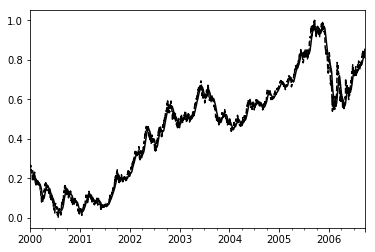

In [242]:
# For viewing various series and validating previous process #

import pandas as pd
import numpy as np
%matplotlib inline

#china_series = all_series["Malaysia"][0:300]
#china_series = all_series["Hong_Kong"]
china_series = all_train["EU"]
#china_series = all_valid["China"]


# some sample data
ts = pd.Series(china_series, index=pd.date_range('1/1/2000', periods=len(china_series)))
#ts = pd.Series(china_series, index=pd.date_range('1/1/2000', periods=300))

#plot the time series
ts.plot(style='k--')

# calculate a 60 day rolling mean and plot
ts.rolling(window=window_size).mean().plot(style='k')


In [205]:
print("Total data instances in training set: " + str(len(x_train_all)))

Total data instances in training set: 44190


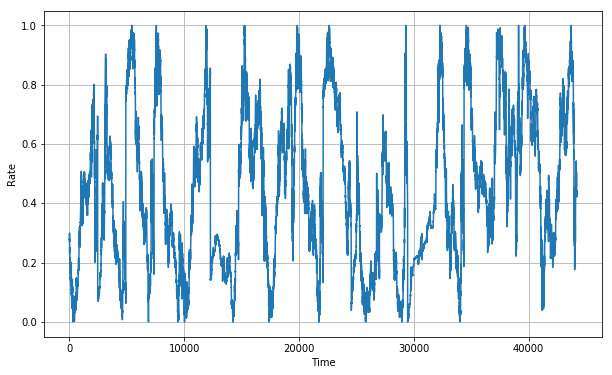

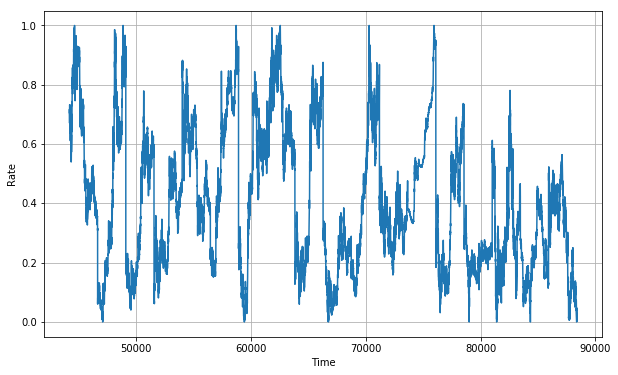

In [206]:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train_all)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid_all)
plt.show()

[800, 1000, 0.0, 0.2]

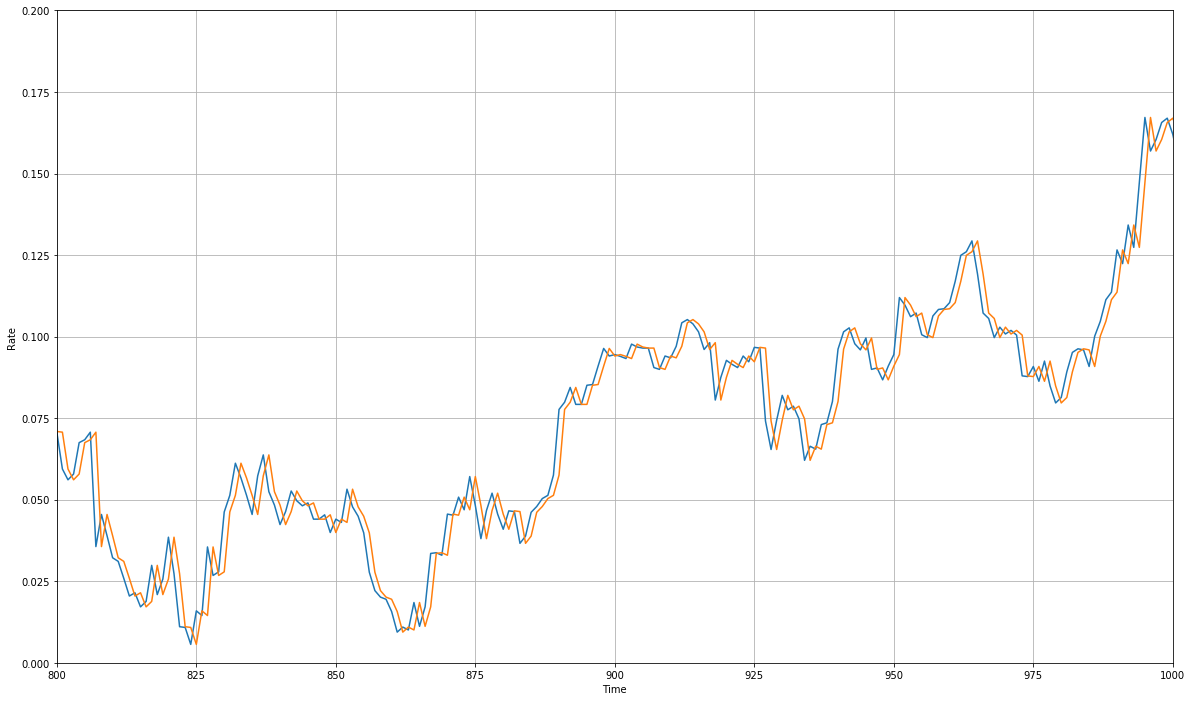

In [56]:
############################################################
# Establishing a forecasting baseline using the
# most naive model, assuming the Rate at the next 
# time step will be exactly what it is at the current one.
# The implied trading strategy for this model would always 
# be ambivalence; therefor, if we cannot improve on this, 
# we cannot trade with our model.
############################################################

split_time = 1
naive_forecast = all_valid["United_Kingdom"][:-1]
plt.figure(figsize=(20, 12))
plot_series(range(len(all_valid["United_Kingdom"])-1), all_valid["United_Kingdom"][1:])
plot_series(range(len(all_valid["United_Kingdom"])-1), naive_forecast)
plt.axis([800, 1000, 0.0, 0.2])

In [55]:
print(tf.keras.metrics.mean_squared_error(all_valid["United_Kingdom"][1:], naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(all_valid["United_Kingdom"][1:], naive_forecast).numpy())


7.767924399573705e-05
0.006171038921889785


In [212]:
# Generate a windowed & batched tensorflow dataset object 
# with the basic hyper parameters defined earlier
train_set = windowed_dataset(x_train_all, window_size, batch_size, shuffle_buffer_size)

# train_set is now an iterable set of window sequences 
# each of length 'window_size'.  Check by looking at them.
#for window_dataset in train_set:
#  for win in window_dataset:
#    print(win.numpy(), end=" ")
#    a = win.numpy().shape
    

In [155]:
# (batch_size - window_size) should equal the number 
# of windows that fit in each batch --> dimension #1
# 
# window_size --> dimension #2
# the number of window_datasets * (batch_size+window_size)
# should equal the number of rows in the training dataset
# unless it's the last batch and even multiples don't exist
#print(a)
#print((224+32)*9)  

(218, 32, 1)
2304


In [213]:
# ONLY RUN THIS CELL ONCE TO DETERMINE 'learning rate'
# Created a callback that scales up the learning rate
# as the training progresses through epochs.  Looking
# for an 'elbow' where the loss ceases to decreas.

run_this = False

if run_this == True:
    tf.keras.backend.clear_session()

    print(train_set)
    print(x_train_all.shape)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1)
    #  tf.keras.layers.Lambda(lambda x: x * 400)
    ])

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
    history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


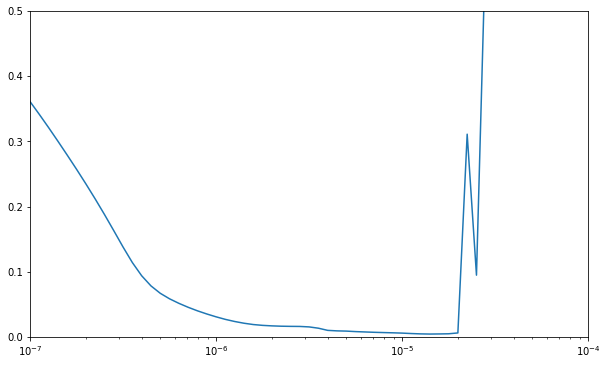

In [44]:
# ONLY RUN THIS CELL ONCE TO VIEW 'learning rate'

if run_this == True:
    plt.figure(figsize=(10, 6))

    plt.semilogx(history.history["lr"], history.history["loss"])
    plt.axis([10e-8, 10e-5, 0, 0.5])
    plt.show()

In [ ]:
tf.keras.backend.clear_session()

train_set = windowed_dataset(x_train_all, window_size, batch_size, shuffle_buffer_size)
val_set   = windowed_dataset(x_valid_all, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
#  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae']) # , 'acc'
history = model.fit(train_set, epochs=100, validation_data = val_set)

Epoch 1/100
277/277 [==============================] - 35s 126ms/step - loss: 0.1325 - mae: 0.4424 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
277/277 [==============================] - 30s 108ms/step - loss: 0.1203 - mae: 0.4154 - val_loss: 0.0953 - val_mae: 0.3669
Epoch 3/100
277/277 [==============================] - 30s 108ms/step - loss: 0.1098 - mae: 0.3917 - val_loss: 0.0866 - val_mae: 0.3440
Epoch 4/100
277/277 [==============================] - 30s 107ms/step - loss: 0.1009 - mae: 0.3708 - val_loss: 0.0791 - val_mae: 0.3232
Epoch 5/100
277/277 [==============================] - 30s 107ms/step - loss: 0.0929 - mae: 0.3518 - val_loss: 0.0724 - val_mae: 0.3045
Epoch 6/100
277/277 [==============================] - 29s 106ms/step - loss: 0.0858 - mae: 0.3346 - val_loss: 0.0664 - val_mae: 0.2877
Epoch 7/100
277/277 [==============================] - 30s 108ms/step - loss: 0.0794 - mae: 0.3188 - val_loss: 0.0610 - val_mae: 0.2726
Epoch 8/100
277/277 [===================

In [ ]:
model.summary()

In [ ]:
import matplotlib.pyplot as plt

# np. newaxis is used to increase the dimension of the existing array 
# by one dimension

rnn_forecast = model_forecast(model, x_valid_all, window_size, cnn=False)
rnn_forecast = rnn_forecast[:x_valid_len-window_size+1, -1, 0]

#rnn_forecast = rnn_forecast[x_train_len - window_size:-1, -1, 0]

plt.figure(figsize=(20, 12))
#plot_series(time_valid, x_valid)
#plot_series(time_valid, rnn_forecast)
plot_series(time_valid[:x_valid_len - window_size+1], x_valid_all[:x_valid_len - window_size+1])
plot_series(time_valid[:x_valid_len - window_size+1], rnn_forecast)

#plt.axis([10e-8, 10e-5, 0, 0.5])
plt.show()

ValueError: Unknown graph. Aborting.

In [243]:
tf.keras.backend.clear_session()

#train_set = windowed_dataset(x_train_all, window_size, batch_size, shuffle_buffer_size)
#val_set   = windowed_dataset(x_valid_all, window_size, batch_size, shuffle_buffer_size)


model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(20, return_sequences=True),
  tf.keras.layers.LSTM(20, return_sequences=True),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
#  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model2.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae']) # , 'acc'
history2 = model2.fit(train_set, epochs=100, validation_data = val_set)

Epoch 1/100
288/288 [==============================] - 28s 97ms/step - loss: 0.1335 - mae: 0.4463 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
288/288 [==============================] - 23s 79ms/step - loss: 0.1237 - mae: 0.4244 - val_loss: 0.1005 - val_mae: 0.3788
Epoch 3/100
288/288 [==============================] - 22s 75ms/step - loss: 0.1151 - mae: 0.4045 - val_loss: 0.0928 - val_mae: 0.3587
Epoch 4/100
288/288 [==============================] - 22s 78ms/step - loss: 0.1070 - mae: 0.3858 - val_loss: 0.0856 - val_mae: 0.3392
Epoch 5/100
288/288 [==============================] - 23s 79ms/step - loss: 0.0996 - mae: 0.3681 - val_loss: 0.0790 - val_mae: 0.3210
Epoch 6/100
288/288 [==============================] - 23s 79ms/step - loss: 0.0926 - mae: 0.3514 - val_loss: 0.0729 - val_mae: 0.3041
Epoch 7/100
288/288 [==============================] - 22s 76ms/step - loss: 0.0863 - mae: 0.3360 - val_loss: 0.0674 - val_mae: 0.2888
Epoch 8/100
288/288 [==========================

KeyboardInterrupt: 

In [84]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

<Figure size 432x288 with 0 Axes>

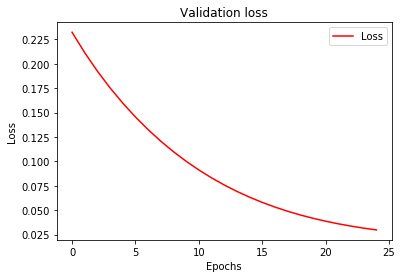

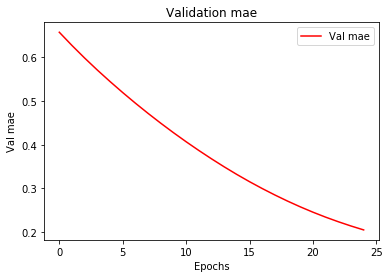

<Figure size 432x288 with 0 Axes>

In [161]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['val_loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

#------------------------------------------------
# Plot validation loss per epoch
#------------------------------------------------
mae=history.history['val_mae']

plt.plot(epochs, mae, 'r')
plt.title('Validation mae')
plt.xlabel("Epochs")
plt.ylabel("Val mae")
plt.legend(["Val mae"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
#zoomed_loss = loss[400:]
#zoomed_epochs = range(400,500)

#plt.plot(zoomed_epochs, zoomed_loss, 'r')
#plt.title('Validation loss')
#plt.xlabel("Epochs")
#plt.ylabel("Loss")
#plt.legend(["Loss"])

#plt.figure()

In [ ]:
# Write resulting dataframe to COS in parquet format
data_url = cos.url(this_stage + ".parquet", bucket_name)
df_all.write.parquet(data_url)

In [ ]:
# Example time-series dataset util

from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
data = np.array([[i] for i in range(50)])
targets = np.array([[i] for i in range(50)])
data_gen = TimeseriesGenerator(data, targets,
                               length=10, sampling_rate=2,
                               batch_size=2)
assert len(data_gen) == 20
batch_0 = data_gen[0]
x, y = batch_0
assert np.array_equal(x,
                      np.array([[[0], [2], [4], [6], [8]],
                                [[1], [3], [5], [7], [9]]]))
assert np.array_equal(y,
                      np.array([[10], [11]]))

In [ ]:
# Example tf dataset method
def _parse_labels_function(example):
    context_features = {
        "labels_length": tf.FixedLenFeature(shape=[], dtype=tf.int64),
        "filename": tf.FixedLenFeature(shape=[], dtype=tf.string)
    }
    sequence_features = {
        "labels": tf.FixedLenSequenceFeature(shape=[], dtype=tf.int64)
    }

    context_parsed, sequence_parsed = tf.parse_single_sequence_example(
        serialized=example,
        context_features=context_features,
        sequence_features=sequence_features
    )

    # Append `10` to each label sequence.
    labels = tf.concat([sequence_parsed["labels"], [10]], 0)

    return labels, context_parsed["labels_length"], context_parsed["filename"]

dataset = tf.data.TFRecordDataset(label_record)
dataset = dataset.map(_parse_labels_function)

In [ ]:

# INCEPTION CODE
#
#!wget --no-check-certificate \
#    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
#  
#from tensorflow.keras.applications.inception_v3 import InceptionV3
#
#local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
#
#pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
#                                include_top = False, 
#                                weights = None)
#
#pre_trained_model.load_weights(local_weights_file)